
<font color=blue|red|green|pink|yellow>Text</font> Etude du flux capté par les pixels après rétrodiffusion¶

On utilise la formule simplifiée de Jean-Michel



In [ ]:
from pylab import *
import scipy as sp
def reflectance_JMT(mua, musp, x):
    """REFLECTANCE_JMT Calcul de la réflectance simplifiée
    
    Formule fournie par Jean-Michel Tualle
    Note: mua et musp en cm-1, x en cm"""

    A = 0.2278 * musp + 1.269;
    B = (8.91e-4 * musp - 0.02895) * musp + 0.9236;
    C = (-0.02091 * musp + 0.5217) * musp + 1.198;
    aA = A * (mua ** B) + C;

    A = (-9.555e-5 * musp + 0.002268) * musp - 0.01532;
    B = (0.002542 * musp - 0.0642) * musp + 0.4052;
    C = (0.02802 * musp - 0.5906) * musp + 4.015;
    aB = (A * mua + B) * mua + C;

    return exp(-(aA*x+aB));

Les constantes suivantes ont été précisées par Jean-Michel et Validées par Anabela

In [ ]:
constantes = {
    'swir': {
        'ua':  [3., 10.],
        'usp': [3., 6.],
        'lambda': [1520., 1700.],
        'ls': 'k--'},
    'nir': {
        'ua':  [0.3, 0.4],
        'usp': [7., 10.],
        'lambda': [950., 1000.],
        'ls': 'm--'},
    'vir': {
        'ua':  [0.05, 0.2],
        'usp': [7., 10.],
        'lambda': [800., 800.],
        'ls': 'r--'}
};

On calcule l'enveloppe des réflectances pour les bornes des mua musp pour chaque domaine

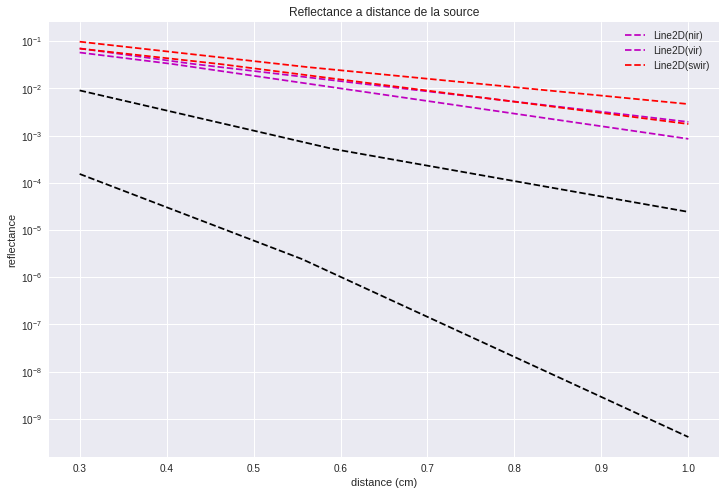

In [ ]:
"""Distance à la source"""
x=linspace(0.3,1.,100)

figure(figsize = (12,8))

all_reflectances = {}
handles = []
"""Iterate through bandwidths"""
for key in constantes.keys():
    #Calcul de toutes les combinaisons µa,µs'
    reflectances = dstack((
        reflectance_JMT(constantes[key]['ua'][0], constantes[key]['usp'][0],x),
        reflectance_JMT(constantes[key]['ua'][0], constantes[key]['usp'][1],x),
        reflectance_JMT(constantes[key]['ua'][1], constantes[key]['usp'][0],x),
        reflectance_JMT(constantes[key]['ua'][1], constantes[key]['usp'][1],x)
    ))
    #Déduction de l'enveloppe min et max
    R=amax(squeeze(reflectances), axis=1)
    r=amin(squeeze(reflectances), axis=1)
    all_reflectances[key] = {}
    all_reflectances[key]['min'] = r;
    all_reflectances[key]['max'] = R;
    all_reflectances[key]['x'] = x;
    #affichage min et max de la reflectance pour cette longueur d'onde
    handles += semilogy(x, r, constantes[key]['ls'], label=key)
    semilogy(x, R, constantes[key]['ls'])
    
gca().legend(handles)
xlabel('distance (cm)')
ylabel('reflectance')
title('Reflectance a distance de la source')
grid(True);
show()



On passe en unités photométriques en prenant en compte la puissance de la source et la longueur d'onde

$$Psource= F \times Eph$$

(avec F le flux en photons par seconde et Eph l'energie du photon)

$$Eph = \frac{h\times c}{lambda}$$

$$F = \frac{Psource\times lambda} {h \times C}$$


Energie par photon en nir : 1.27 eV
Flux de la source (1.0 mW) en nir : 5e+15 ph/sec
Energie par photon en vir : 1.55 eV
Flux de la source (1.0 mW) en vir : 4e+15 ph/sec
Energie par photon en swir : 0.77 eV
Flux de la source (1.0 mW) en swir : 8e+15 ph/sec


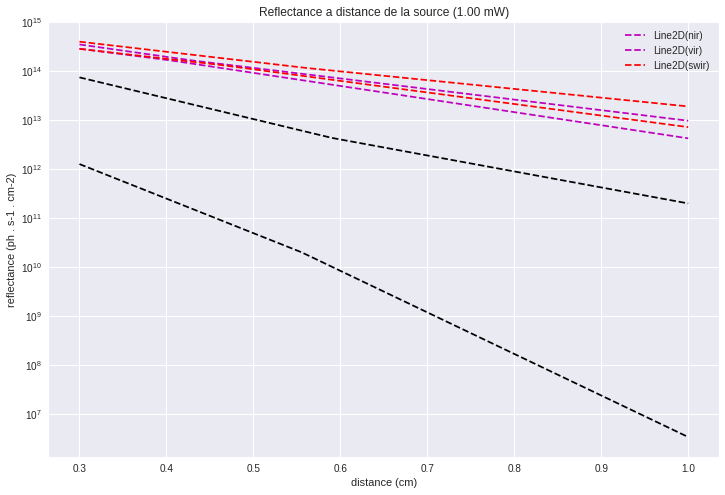

In [ ]:
Planck=6.626070040e-34
C=299792458
hc=Planck*C
puissance_source=1e-3

figure(figsize=(12,8))
handles=[]

#Pour chaque longueur d'onde
for key in all_reflectances.keys():
    #We take the average of lambdas of the band
    lambda_ = sum(constantes[key]['lambda']) / len(constantes[key]['lambda'])

    #calcul de Eph l'energie du photon
    e_per_ph = hc / (lambda_ * 1e-9)
    print("Energie par photon en %s : %.2f eV" % (key, e_per_ph / 1.6e-19))

    #calcul du flux
    F = puissance_source / e_per_ph
    print("Flux de la source (%.1f mW) en %s : %.1g ph/sec" % (puissance_source * 1e3, key, F))
    
    #Tracé de la reflectance min et max (reflectance * F)
    handles += semilogy(all_reflectances[key]['x'], all_reflectances[key]['min'] * F, constantes[key]['ls'],label=key)
    semilogy(all_reflectances[key]['x'], all_reflectances[key]['max'] * F, constantes[key]['ls'])

gca().legend(handles)
xlabel('distance (cm)')
ylabel('reflectance (ph . s-1 . cm-2)')
title('Reflectance a distance de la source (%.2f mW)' % (puissance_source * 1e3))
grid(True);
show()



Application au cas d'un pixel de 10x10 µm² et d'une ouverture de 1/2

Revoir avec les infos de JMT:

```
Bonjour,
Voila ce que j'ai pour l'ouverture numérique, pour une photodiode dans un conduit cylindrique aux parois absorbantes (de diamètre D et de longueur L, soit une ouverture numérique ON=D/[2L] ), sans prise en compte de la réflexion de Fresnel à la surface de la photodiode.

Si Theta_max = arcsin[ON], alors 
Flux_Photodiode = Emittance x Surface x [1-(cos(Theta_max))^2]

Si  D<<L,  cos(Theta_max)~1-Theta_max^2/2 et 
Theta_max ~ ON, 
soit Flux_Photodiode = Emittance x Surface x  ON^2

Amicalement,
JMT
```


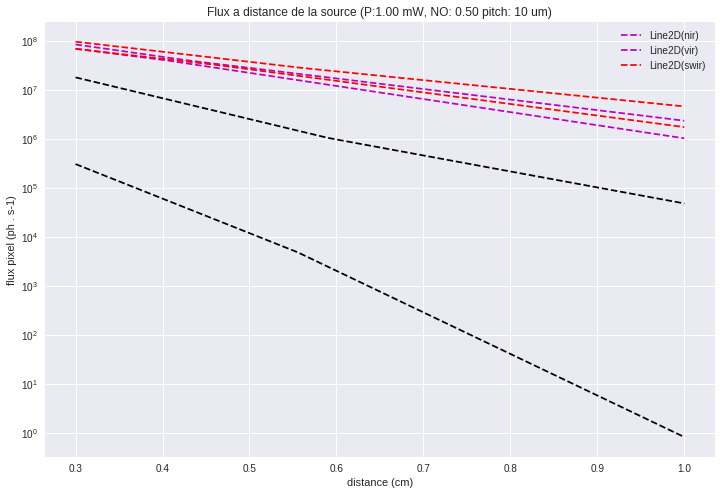

In [ ]:
pixel_pitch=10e-6
NO=0.5

pixel_pitch_cm=pixel_pitch * 100
captance = pixel_pitch_cm * pixel_pitch_cm * NO / 2

figure(figsize=(12,8))
handles=[]

#Pour chaque longueur d'onde
for key in all_reflectances.keys():
    #We take the average of lambdas of the band
    lambda_ = sum(constantes[key]['lambda']) / len(constantes[key]['lambda'])
    #calcul de Eph l'energie du photon
    e_per_ph = hc / (lambda_ * 1e-9)
    #calcul de Dph, le débit de photons
    F = puissance_source / e_per_ph
    
    #tracé du flux par pixel
    handles += semilogy(all_reflectances[key]['x'], all_reflectances[key]['min'] * F * captance, constantes[key]['ls'],label=key)
    semilogy(all_reflectances[key]['x'], all_reflectances[key]['max'] * F * captance, constantes[key]['ls'])

gca().legend(handles)
xlabel('distance (cm)')
ylabel('flux pixel (ph . s-1)')
title('Flux a distance de la source (P:%.2f mW, NO: %.2f pitch: %d um)' % (puissance_source * 1e3,NO,pixel_pitch * 1e6))
grid(True);
show()